# Configuration

In [ ]:
import os
import pathlib
from typing import Iterable, Tuple, Dict, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# in/out files
DATA_DIR         = pathlib.Path("data")
INPUT_CSV        = DATA_DIR / "NewCDMergedData.csv"
OUTPUT_CLEAN_DIR = DATA_DIR / "clean"
OUTPUT_ANALYZE_DIR = pathlib.Path("analiza")

# prefixes
BASE_WITH_VECS    = "dataset_with_vec_expanded"
BASE_WITHOUT_VECS = "dataset_without_vec_expanded"

# CSV separator and loading settings
CSV_SEP     = ";"
CSV_DECIMAL = ","
CSV_INDEX_COL = 0

# target col
TARGET_COL: Optional[str] = "DeltaG"

 # Lists of columns to drop
COLS_TO_DROP = [
    "Host","CID_Host","Guest","CID_Guest","pH","T","Erreur","K","logK",
    "Reference","Original_Value","IsomericSMILES","IsomericSMILES_Host",
    "AromaticProportion",
    "TPSA_Host","MolecularWeight_Host","Complexity_Host","Charge_Host",
    "HBondDonorCount_Host","HBondAcceptorCount_Host","HeavyAtomCount_Host",
    "iso2vec-0","iso2vec-1","iso2vec-2","iso2vec-3","iso2vec-4","iso2vec-5",
    "iso2vec-6","iso2vec-7","iso2vec-8","iso2vec-9",
    "iso2vec-host-0","iso2vec-host-1","iso2vec-host-2","iso2vec-host-3",
    "iso2vec-host-4","iso2vec-host-5","iso2vec-host-6","iso2vec-host-7",
    "iso2vec-host-8","iso2vec-host-9",
]
COLS_TO_DROP_WITHOUT_VECS = [
    "Host","CID_Host","Guest","CID_Guest","pH","T","Erreur","K","logK",
    "Reference","Original_Value","IsomericSMILES","IsomericSMILES_Host",
    "AromaticProportion",
    "TPSA_Host","MolecularWeight_Host","Complexity_Host","Charge_Host",
    "HBondDonorCount_Host","HBondAcceptorCount_Host","HeavyAtomCount_Host",
]

# Visualization
CORR_CMAP = "inferno"  
FIGSIZE_CORR = (10, 8)

OUTPUT_CLEAN_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_ANALYZE_DIR.mkdir(parents=True, exist_ok=True)

MISSING_COL_DROP_PCT: float | None = 0.98  
MISSING_ROW_DROP_PCT: float | None = None  

IMPUTE_NUM = "median"   
IMPUTE_CAT = "mode"     

CORR_MAX_LABELS = 80        
CORR_DPI = 220              
CORR_SAVE = True            
CORR_OUTDIR = OUTPUT_ANALYZE_DIR / "corr"
CORR_TOPK = 4000              
CORR_MIN_ABS = 0.7          



# Functions

In [ ]:
def drop_constant_columns(df: pd.DataFrame,
                          keep: Iterable[str] = (),
                          dropna: bool = False) -> Tuple[pd.DataFrame, pd.Index]:
    """Remove columns that have <= 1 unique value."""
    keep = set(keep)
    const_cols = df.columns[df.nunique(dropna=dropna) <= 1]
    const_cols = pd.Index([c for c in const_cols if c not in keep])
    return df.drop(columns=const_cols, errors="ignore").copy(), const_cols


def make_overview(df: pd.DataFrame) -> pd.DataFrame:
    """Overview table of deficiencies/uniqueness/types."""
    return (
        pd.DataFrame({
            "dtype":      df.dtypes,
            "non_null":   df.count(),
            "nulls":      df.isna().sum(),
            "null_%":     df.isna().mean() * 100,
            "unique_cnt": df.nunique(dropna=True),
        })
        .sort_values("null_%", ascending=False)
    )


def numeric_stats_with_outliers(df: pd.DataFrame,
                                percentiles=(.05,.25,.5,.75,.95)) -> pd.DataFrame:
    """Returns outliers statistics"""
    num = df.select_dtypes(include="number")
    if num.shape[1] == 0:
        return pd.DataFrame()

    stats = num.describe(percentiles=list(percentiles)).T

    # Outlier IQR
    Q1 = num.quantile(0.25)
    Q3 = num.quantile(0.75)
    IQR = Q3 - Q1
    outlier_mask   = (num < (Q1 - 1.5 * IQR)) | (num > (Q3 + 1.5 * IQR))
    outlier_counts = outlier_mask.sum()

    stats["outlier_count"] = outlier_counts
    stats.insert(stats.columns.get_loc("outlier_count") + 1,
                 "unique_count",
                 num.nunique(dropna=True))
    return stats


def plot_corr(df: pd.DataFrame, title: str, cmap: str = CORR_CMAP):
    """Generate correlation plot"""
    num_cols = df.select_dtypes(include="number").columns
    if len(num_cols) < 2:
        print(f"[{title}] Za mało kolumn numerycznych do korelacji (min 2).")
        return
    corr = df[num_cols].corr(method="pearson")
    plt.figure(figsize=FIGSIZE_CORR)
    plt.imshow(corr, interpolation="nearest", cmap=cmap)
    plt.colorbar()
    plt.xticks(range(len(num_cols)), num_cols, rotation=90)
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title(title)
    plt.tight_layout()
    plt.show()


def scale_numeric_inplace(df: pd.DataFrame,
                          exclude: Iterable[str] = (),
                          scaler: Optional[StandardScaler] = None) -> Tuple[pd.DataFrame, StandardScaler, pd.Index]:
    """
    Feature standarization.
    """
    exclude = set([c for c in exclude if c in df.columns])
    num_cols = df.select_dtypes(include="number").columns
    cols_to_scale = pd.Index([c for c in num_cols if c not in exclude])

    if len(cols_to_scale) == 0:
        return df, (scaler or StandardScaler().fit(np.zeros((1,1)))), cols_to_scale

    scaler = scaler or StandardScaler()
    df.loc[:, cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
    return df, scaler, cols_to_scale


def save_df(df: pd.DataFrame, out_dir: pathlib.Path, base_name: str, suffix: str = ""):
    """Save dataset."""
    out_dir.mkdir(parents=True, exist_ok=True)
    suf = f"_{suffix}" if suffix else ""
    df.to_parquet(out_dir / f"{base_name}{suf}.parquet", index=False)
    df.to_csv(out_dir / f"{base_name}{suf}.csv", index=False)


def run_full_report_for_view(df_view: pd.DataFrame,
                             view_name: str,
                             analyze_dir: pathlib.Path = OUTPUT_ANALYZE_DIR,
                             corr_title_suffix: str = "") -> Dict[str, object]:
    """
    Runs full report for one view
    """
    print(f"\n=== [{view_name}] OVERVIEW ===")
    overview = make_overview(df_view)
    try:
        display(overview)
    except Exception:
        print(overview.head(20))

    print(f"\n=== [{view_name}] INFO (memory) ===")
    df_view.info(memory_usage="deep")

    dupes = df_view.duplicated().sum()
    print(f"\n=== [{view_name}] DUPLICATES ===\nDuplicated rows: {dupes}")

    stats = numeric_stats_with_outliers(df_view)
    stats_path = analyze_dir / f"{view_name}_stats.md"
    if not stats.empty:
        stats.to_markdown(stats_path)
        print(f"\n[{view_name}] Statystyki zapisane do: {stats_path}")
    else:
        print(f"\n[{view_name}] Brak kolumn numerycznych – statystyki pominięte.")

    plot_corr(df_view, title=f"Correlation matrix (Pearson) {corr_title_suffix} [{view_name}]")

    return {"overview": overview, "stats": stats, "dupes": dupes}

def handle_missing(df: pd.DataFrame,
                   drop_col_thresh: float | None = MISSING_COL_DROP_PCT,
                   drop_row_thresh: float | None = MISSING_ROW_DROP_PCT,
                   exclude: list[str] = None) -> tuple[pd.DataFrame, dict]:
    """
    Imputation and optional columns and rows dropping
    """
    exclude = set(exclude or [])
    meta: dict = {}

    # 1) Drop cols
    if drop_col_thresh is not None:
        na_frac = df.isna().mean()
        cols_to_drop = na_frac.index[na_frac >= drop_col_thresh]
        meta["dropped_cols_missing"] = list(cols_to_drop)
        df = df.drop(columns=cols_to_drop, errors="ignore")

    # 2) Drop rows
    if drop_row_thresh is not None:
        row_na_frac = df.isna().mean(axis=1)
        to_drop_idx = row_na_frac.index[row_na_frac >= drop_row_thresh]
        meta["dropped_rows_missing_count"] = len(to_drop_idx)
        df = df.drop(index=to_drop_idx)

    # 3) Imputation
    num_cols = df.select_dtypes(include="number").columns.difference(exclude)
    cat_cols = df.columns.difference(num_cols).difference(exclude)

    if len(num_cols) > 0:
        if IMPUTE_NUM == "median":
            fill_num = df[num_cols].median()
        elif IMPUTE_NUM == "mean":
            fill_num = df[num_cols].mean()
        else:
            raise ValueError("IMPUTE_NUM must be 'median' or 'mean'")
        df[num_cols] = df[num_cols].fillna(fill_num)

    if len(cat_cols) > 0:
        modes = {c: df[c].mode(dropna=True).iloc[0] if not df[c].mode(dropna=True).empty else "" for c in cat_cols}
        df[cat_cols] = df[cat_cols].fillna(pd.Series(modes))

    meta["remaining_nan_after_impute"] = int(df.isna().sum().sum())
    return df, meta


def reorder_by_corr_strength(corr: pd.DataFrame) -> list[str]:
    """
    Reorder dataset by correlation streangth
    """
    C = corr.abs().copy()
    np.fill_diagonal(C.values, 0.0)
    i, j = np.unravel_index(np.nanargmax(C.values), C.shape)
    order = [corr.index[i], corr.index[j]]
    remaining = [c for c in corr.columns if c not in order]
    while remaining:
        scores = {c: C.loc[order, c].mean() for c in remaining}
        best = max(scores, key=scores.get)
        order.append(best)
        remaining.remove(best)
    return order


def plot_corr_readable(df: pd.DataFrame, title: str,
                       out_png: str | None = None,
                       max_labels: int = CORR_MAX_LABELS,
                       cmap: str = CORR_CMAP,
                       dpi: int = CORR_DPI):
    num_cols = df.select_dtypes(include="number").columns
    if len(num_cols) < 2:
        print(f"[{title}] Za mało kolumn numerycznych (min 2).")
        return

    corr = df[num_cols].corr(method="pearson")
    order = reorder_by_corr_strength(corr)
    corr = corr.loc[order, order]
    n = len(order)

    side = max(6, min(0.25 * n, 30))
    plt.figure(figsize=(side, side))
    plt.imshow(corr, interpolation="nearest", cmap=cmap, vmin=-1, vmax=1)
    plt.colorbar()
    plt.title(title)

    if n <= max_labels:
        plt.xticks(range(n), order, rotation=90, fontsize=8)
        plt.yticks(range(n), order, fontsize=8)
    else:
        step = int(np.ceil(n / max_labels))
        idxs = np.arange(0, n, step)
        labels = [order[i] for i in idxs]
        plt.xticks(idxs, labels, rotation=90, fontsize=8)
        plt.yticks(idxs, labels, fontsize=8)

    plt.tight_layout()
    if out_png:
        plt.savefig(out_png, dpi=dpi, bbox_inches="tight")
        print(f"[corr] zapisano: {out_png}")
    plt.show()


def report_top_correlations(df: pd.DataFrame,
                            view_name: str,
                            out_dir: pathlib.Path = OUTPUT_ANALYZE_DIR,
                            topk: int = CORR_TOPK,
                            min_abs: float = CORR_MIN_ABS) -> pd.DataFrame:
    """Saves and returns top-k pairs"""
    num = df.select_dtypes(include="number")
    if num.shape[1] < 2:
        return pd.DataFrame()

    corr = num.corr().abs()
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    pairs = []
    cols = corr.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            r = corr.iloc[i, j]
            if np.isnan(r): 
                continue
            if r >= min_abs:
                pairs.append((cols[i], cols[j], float(r)))
    pairs.sort(key=lambda x: x[2], reverse=True)
    df_pairs = pd.DataFrame(pairs[:topk], columns=["feature_1","feature_2","abs_r"])

    if not df_pairs.empty:
        out_path = out_dir / f"{view_name}_top_correlations.md"
        out_dir.mkdir(parents=True, exist_ok=True)
        df_pairs.to_markdown(out_path, index=False)
        print(f"[{view_name}] top-k korelacje zapisane do: {out_path}")
    return df_pairs


# Laoding data


In [ ]:
df = pd.read_csv(
    INPUT_CSV,
    index_col=CSV_INDEX_COL,
    on_bad_lines="warn",
    sep=CSV_SEP,
    decimal=CSV_DECIMAL,
)

try:
    display(df.sample(10))
except Exception:
    print(df.sample(10))

print("\n=== INFO (raw) ===")
df.info()


,Host,CID_Host,Guest,CID_Guest,pH,T,DeltaG,Erreur,K,logK,...,Shadow area fraction: YZ plane (Spatial Descriptors),Shadow area fraction: ZX plane (Spatial Descriptors),Shadow length: LX (Spatial Descriptors),Shadow length: LY (Spatial Descriptors),Shadow length: LZ (Spatial Descriptors),Shadow ratio (Spatial Descriptors),Connolly surface area (Atom Volumes and Surfaces),Connolly surface occupied volume (Atom Volumes and Surfaces),Solvent surface area (Atom Volumes and Surfaces),Solvent surface occupied volume (Atom Volumes and Surfaces)
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1208,beta-cyclodextrin,444041,cyclohexanone,7967.0,7,298,-15.45,0,510,NaN,...,0.721133,0.662150,8.113916,6.746158,5.203029,1.559460,131.776295,115.996511,278.915783,403.043878
1828,beta-cyclodextrin,444041,trifluoroacetanilide,67881.0,7,298,-11.06,0,87,NaN,...,0.658659,0.658303,12.224506,7.396794,5.343668,2.287662,199.445106,176.192996,389.728450,589.973075
2795,beta-cyclodextrin,444041,CNC(=O)OC1=CC=CC2=CC=CC=C12,NaN,7,298,-14.04,NaN,289,5.67,...,0.643519,0.652702,12.098722,9.446054,5.325812,2.271714,213.527401,191.791712,411.255054,630.545078
975,beta-cyclodextrin,444041,phenanthridine,9189.0,7,298,-14.67,0,373,NaN,...,0.759690,0.770686,9.218500,8.521767,3.400208,2.711158,165.067948,144.299671,329.873182,487.943609
1748,beta-cyclodextrin,444041,4-hydroxycoumarin,21788012.0,7,298,-13.13,0,200,NaN,...,0.660417,0.668687,13.123751,6.200112,5.955887,2.203492,204.650968,175.735628,404.833596,606.606496
670,beta-cyclodextrin,444041,4-fluorophenol,9732.0,7,298,-9.87,0,54,NaN,...,0.664706,0.732653,9.657100,6.721100,3.960000,2.438662,136.715461,116.138001,289.926043,412.857408
207,beta-cyclodextrin,444041,3-carene,26049.0,7,298,-20.26,0,3561,NaN,...,0.653846,0.695652,9.169585,5.945513,5.110310,1.794330,132.179584,110.804781,282.699207,400.571800
1246,beta-cyclodextrin,444041,"3,4-dihydroxybenzoic acid",72.0,7,298,-15.19,0,459,NaN,...,0.753086,0.776667,9.933769,7.184035,3.401463,2.920440,151.828649,129.025260,311.776888,450.451149
1699,beta-cyclodextrin,444041,n-(4-carboxyphenyl)anthranilic acid,205082.0,7,298,-18.02,0,1440,NaN,...,0.684416,0.668571,11.921905,8.769713,6.960754,1.712732,247.015529,227.939184,459.271595,724.557785



=== INFO (raw) ===
<class 'pandas.core.frame.DataFrame'>
Index: 980 entries, 1246 to 3165
Columns: 248 entries, Host to Solvent surface occupied volume (Atom Volumes and Surfaces)
dtypes: float64(150), int64(61), object(37)
memory usage: 1.9+ MB



# Filters
- `Host == "beta-cyclodextrin"`, `pH == 7.0`, `T == 298.0`.


In [ ]:
df = df[
    (df["Host"] == "beta-cyclodextrin") &
    (df["pH"]   == 7.0) &
    (df["T"]    == 298.0)
].copy()

try:
    display(df.sample(10))
except Exception:
    print(df.sample(10))


,Host,CID_Host,Guest,CID_Guest,pH,T,DeltaG,Erreur,K,logK,...,Shadow area fraction: YZ plane (Spatial Descriptors),Shadow area fraction: ZX plane (Spatial Descriptors),Shadow length: LX (Spatial Descriptors),Shadow length: LY (Spatial Descriptors),Shadow length: LZ (Spatial Descriptors),Shadow ratio (Spatial Descriptors),Connolly surface area (Atom Volumes and Surfaces),Connolly surface occupied volume (Atom Volumes and Surfaces),Solvent surface area (Atom Volumes and Surfaces),Solvent surface occupied volume (Atom Volumes and Surfaces)
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2767,beta-cyclodextrin,444041,CC(=O)N[C@@H](CC1=CC=C(O)C=C1)C(=O)O,NaN,7,298,-12.06,NaN,130,4.87,...,0.708882,0.648214,13.890401,7.452996,6.389689,2.173878,234.816476,216.220862,441.564790,694.937051
1000,beta-cyclodextrin,444041,triamcinolone,31307.0,7,298,-19.27,0,2387,NaN,...,0.685185,0.668473,8.006764,6.712281,5.205473,1.538144,128.474569,109.477403,274.219256,390.135599
696,beta-cyclodextrin,444041,mefenamic acid,4044.0,7,298,-15.9,0,613,NaN,...,0.656929,0.681250,12.808140,9.028809,6.362052,2.013209,252.355470,235.229320,464.638377,741.332359
2917,beta-cyclodextrin,444041,CC(=O)ON[C@H](CC1=CC=CC=C1)C(=O)OC1=CC=C([N+](...,NaN,7,298,-15.56,NaN,535,6.28,...,0.668571,0.733977,14.769076,11.924812,6.831660,2.161858,332.401601,317.347610,595.654779,975.392618
1725,beta-cyclodextrin,444041,"3,5-dinitrobenzoic acid",1550467.0,7,298,-17.67,0,1250,NaN,...,0.702778,0.755634,14.160176,7.170871,3.844310,3.683412,199.228846,170.507164,395.410265,586.793923
1301,beta-cyclodextrin,444041,4-dodecylbenzenesulfonate,4378467.0,7,298,-21.95,0,7040,NaN,...,0.661290,0.655389,8.121722,6.627654,6.151630,1.320255,140.452330,125.926865,290.914474,427.171091
3085,beta-cyclodextrin,444041,CC1=CC=C(CN)C=C1,NaN,7,298,-11.87,NaN,120,4.79,...,0.676471,0.663846,10.350922,6.721861,4.823430,2.145967,157.741868,134.591191,323.732424,470.946401
1726,beta-cyclodextrin,444041,ephedrine,9294.0,7,298,-12.82,0,177,NaN,...,0.767399,0.700000,8.931572,7.716534,5.472705,1.632021,178.673605,176.278592,344.791811,545.362315
1773,beta-cyclodextrin,444041,methyl red,10303.0,7,298,-13.58,0,240,NaN,...,0.673337,0.639675,16.574131,8.459086,8.432688,1.965462,365.223737,424.444388,612.000895,1117.491000


In [ ]:
df, const_cols = drop_constant_columns(df, keep=(), dropna=False)
print(f"Stałe kolumny ({len(const_cols)}): {list(const_cols)}")

Stałe kolumny (69): ['Host', 'CID_Host', 'pH', 'T', 'IsomericSMILES_Host', 'Charge_Host', 'HBondDonorCount_Host', 'HBondAcceptorCount_Host', 'HeavyAtomCount_Host', 'iso2vec-host-0', 'iso2vec-host-1', 'iso2vec-host-2', 'iso2vec-host-3', 'iso2vec-host-4', 'iso2vec-host-5', 'iso2vec-host-6', 'iso2vec-host-7', 'iso2vec-host-8', 'iso2vec-host-9', 'Acid anhydride (Fragment Counts)', 'Acid chloride (Fragment Counts)', 'Azo (Fragment Counts)', 'B-dicarbonyl (Fragment Counts)', 'Diazo+ (Fragment Counts)', 'Hydrazone (Fragment Counts)', 'Peroxide (Fragment Counts)', 'Phosphate (Fragment Counts)', 'Sulfoxy chloride (Fragment Counts)', 'Sulfoxy ester (Fragment Counts)', 'Butadiene (Fragment Counts)', 'Propylene (Fragment Counts)', 'Cytosine (Fragment Counts)', 'Total charge (Atomistic Descriptors)', 'E-state keys (sums): S_ddC (Fast Descriptors)', 'E-state keys (sums): S_dNH  (Fast Descriptors)', 'E-state keys (sums): S_sPH2 (Fast Descriptors)', 'E-state keys (sums): S_ssPH (Fast Descriptors)', 'E


- `df_with_vecs` – dataset with iso2vecs,
- `df_without_vecs` – dataset without iso2vecs.

In [ ]:
df_with_vecs = df.drop(columns=COLS_TO_DROP_WITHOUT_VECS, errors="ignore").copy()
df_without_vecs = df.drop(columns=COLS_TO_DROP, errors="ignore").copy()

print("df_with_vecs shape:", df_with_vecs.shape)
print("df_without_vecs shape:", df_without_vecs.shape)

try:
    display(df_with_vecs.head())
    display(df_without_vecs.head())
except Exception:
    print(df_with_vecs.head())
    print(df_without_vecs.head())


df_with_vecs shape: (980, 167)
df_without_vecs shape: (980, 157)


,DeltaG,TPSA,MolecularWeight,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,HeavyAtomCount,MolLogP,iso2vec-0,...,Shadow area fraction: YZ plane (Spatial Descriptors),Shadow area fraction: ZX plane (Spatial Descriptors),Shadow length: LX (Spatial Descriptors),Shadow length: LY (Spatial Descriptors),Shadow length: LZ (Spatial Descriptors),Shadow ratio (Spatial Descriptors),Connolly surface area (Atom Volumes and Surfaces),Connolly surface occupied volume (Atom Volumes and Surfaces),Solvent surface area (Atom Volumes and Surfaces),Solvent surface occupied volume (Atom Volumes and Surfaces)
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1246,-15.19,77.76,154.12099999999998,292.492089776386,0.0,3.0,3.0,11.0,0.7959999999999998,0.7709077,...,0.753086,0.776667,9.933769,7.184035,3.401463,2.920440,151.828649,129.025260,311.776888,450.451149
1353,-13.13,37.3,150.177,228.57786591623355,0.0,1.0,1.0,11.0,1.7038,0.5064067,...,0.677560,0.650973,11.788064,6.715064,5.250551,2.245110,173.848935,150.638121,349.949661,518.285489
763,-12.34,40.46,124.13899999999995,178.61256853719752,0.0,2.0,2.0,9.0,0.8845000000000001,0.4964292,...,0.660539,0.655142,9.282122,6.740753,4.775650,1.943635,142.394646,119.853872,298.042889,427.399640
1749,-12.35,40.46,124.13899999999995,178.61256853719752,0.0,2.0,2.0,9.0,0.8845000000000001,0.4964292,...,0.660539,0.655142,9.282122,6.740753,4.775650,1.943635,142.394646,119.853872,298.042889,427.399640
743,-9.99,37.3,122.12299999999996,200.66106510209755,0.0,1.0,2.0,9.0,1.2047,0.48575255,...,0.736508,0.787037,9.512139,6.993589,3.400583,2.797209,135.699999,112.722833,287.293761,405.131920


,DeltaG,TPSA,MolecularWeight,Complexity,Charge,HBondDonorCount,HBondAcceptorCount,HeavyAtomCount,MolLogP,Amide (Fragment Counts),...,Shadow area fraction: YZ plane (Spatial Descriptors),Shadow area fraction: ZX plane (Spatial Descriptors),Shadow length: LX (Spatial Descriptors),Shadow length: LY (Spatial Descriptors),Shadow length: LZ (Spatial Descriptors),Shadow ratio (Spatial Descriptors),Connolly surface area (Atom Volumes and Surfaces),Connolly surface occupied volume (Atom Volumes and Surfaces),Solvent surface area (Atom Volumes and Surfaces),Solvent surface occupied volume (Atom Volumes and Surfaces)
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
1246,-15.19,77.76,154.12099999999998,292.492089776386,0.0,3.0,3.0,11.0,0.7959999999999998,0,...,0.753086,0.776667,9.933769,7.184035,3.401463,2.920440,151.828649,129.025260,311.776888,450.451149
1353,-13.13,37.3,150.177,228.57786591623355,0.0,1.0,1.0,11.0,1.7038,0,...,0.677560,0.650973,11.788064,6.715064,5.250551,2.245110,173.848935,150.638121,349.949661,518.285489
763,-12.34,40.46,124.13899999999995,178.61256853719752,0.0,2.0,2.0,9.0,0.8845000000000001,0,...,0.660539,0.655142,9.282122,6.740753,4.775650,1.943635,142.394646,119.853872,298.042889,427.399640
1749,-12.35,40.46,124.13899999999995,178.61256853719752,0.0,2.0,2.0,9.0,0.8845000000000001,0,...,0.660539,0.655142,9.282122,6.740753,4.775650,1.943635,142.394646,119.853872,298.042889,427.399640
743,-9.99,37.3,122.12299999999996,200.66106510209755,0.0,1.0,2.0,9.0,1.2047,0,...,0.736508,0.787037,9.512139,6.993589,3.400583,2.797209,135.699999,112.722833,287.293761,405.131920


# Data cleaning 


In [ ]:
views_cleaned = {}
missing_reports = {}

for name, dfv in {
    "with_vecs": df_with_vecs.apply(pd.to_numeric, errors="ignore"),
    "without_vecs": df_without_vecs.apply(pd.to_numeric, errors="ignore"),
}.items():
    exclude = [TARGET_COL] if (TARGET_COL and TARGET_COL in dfv.columns) else []
    dfv2, meta = handle_missing(dfv, drop_col_thresh=MISSING_COL_DROP_PCT,
                                drop_row_thresh=MISSING_ROW_DROP_PCT,
                                exclude=exclude)
    print(f"\n[{name}] missing meta:", meta)

    dfv2, const_after = drop_constant_columns(dfv2, keep=exclude, dropna=False)
    if len(const_after):
        print(f"[{name}] Stałe kolumny po imputacji: {list(const_after)}")

    views_cleaned[name] = dfv2
    missing_reports[name] = meta

df_with_vecs    = views_cleaned["with_vecs"]
df_without_vecs = views_cleaned["without_vecs"]



[with_vecs] missing meta: {'dropped_cols_missing': [], 'remaining_nan_after_impute': 0}

[without_vecs] missing meta: {'dropped_cols_missing': [], 'remaining_nan_after_impute': 0}


C:\Users\jakub\AppData\Local\Temp\ipykernel_26404\1780975186.py:6: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  "with_vecs": df_with_vecs.apply(pd.to_numeric, errors="ignore"),
C:\Users\jakub\AppData\Local\Temp\ipykernel_26404\1780975186.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  "without_vecs": df_without_vecs.apply(pd.to_numeric, errors="ignore"),



# Reports


[corr] zapisano: analiza\corr\corr_with_vecs.png


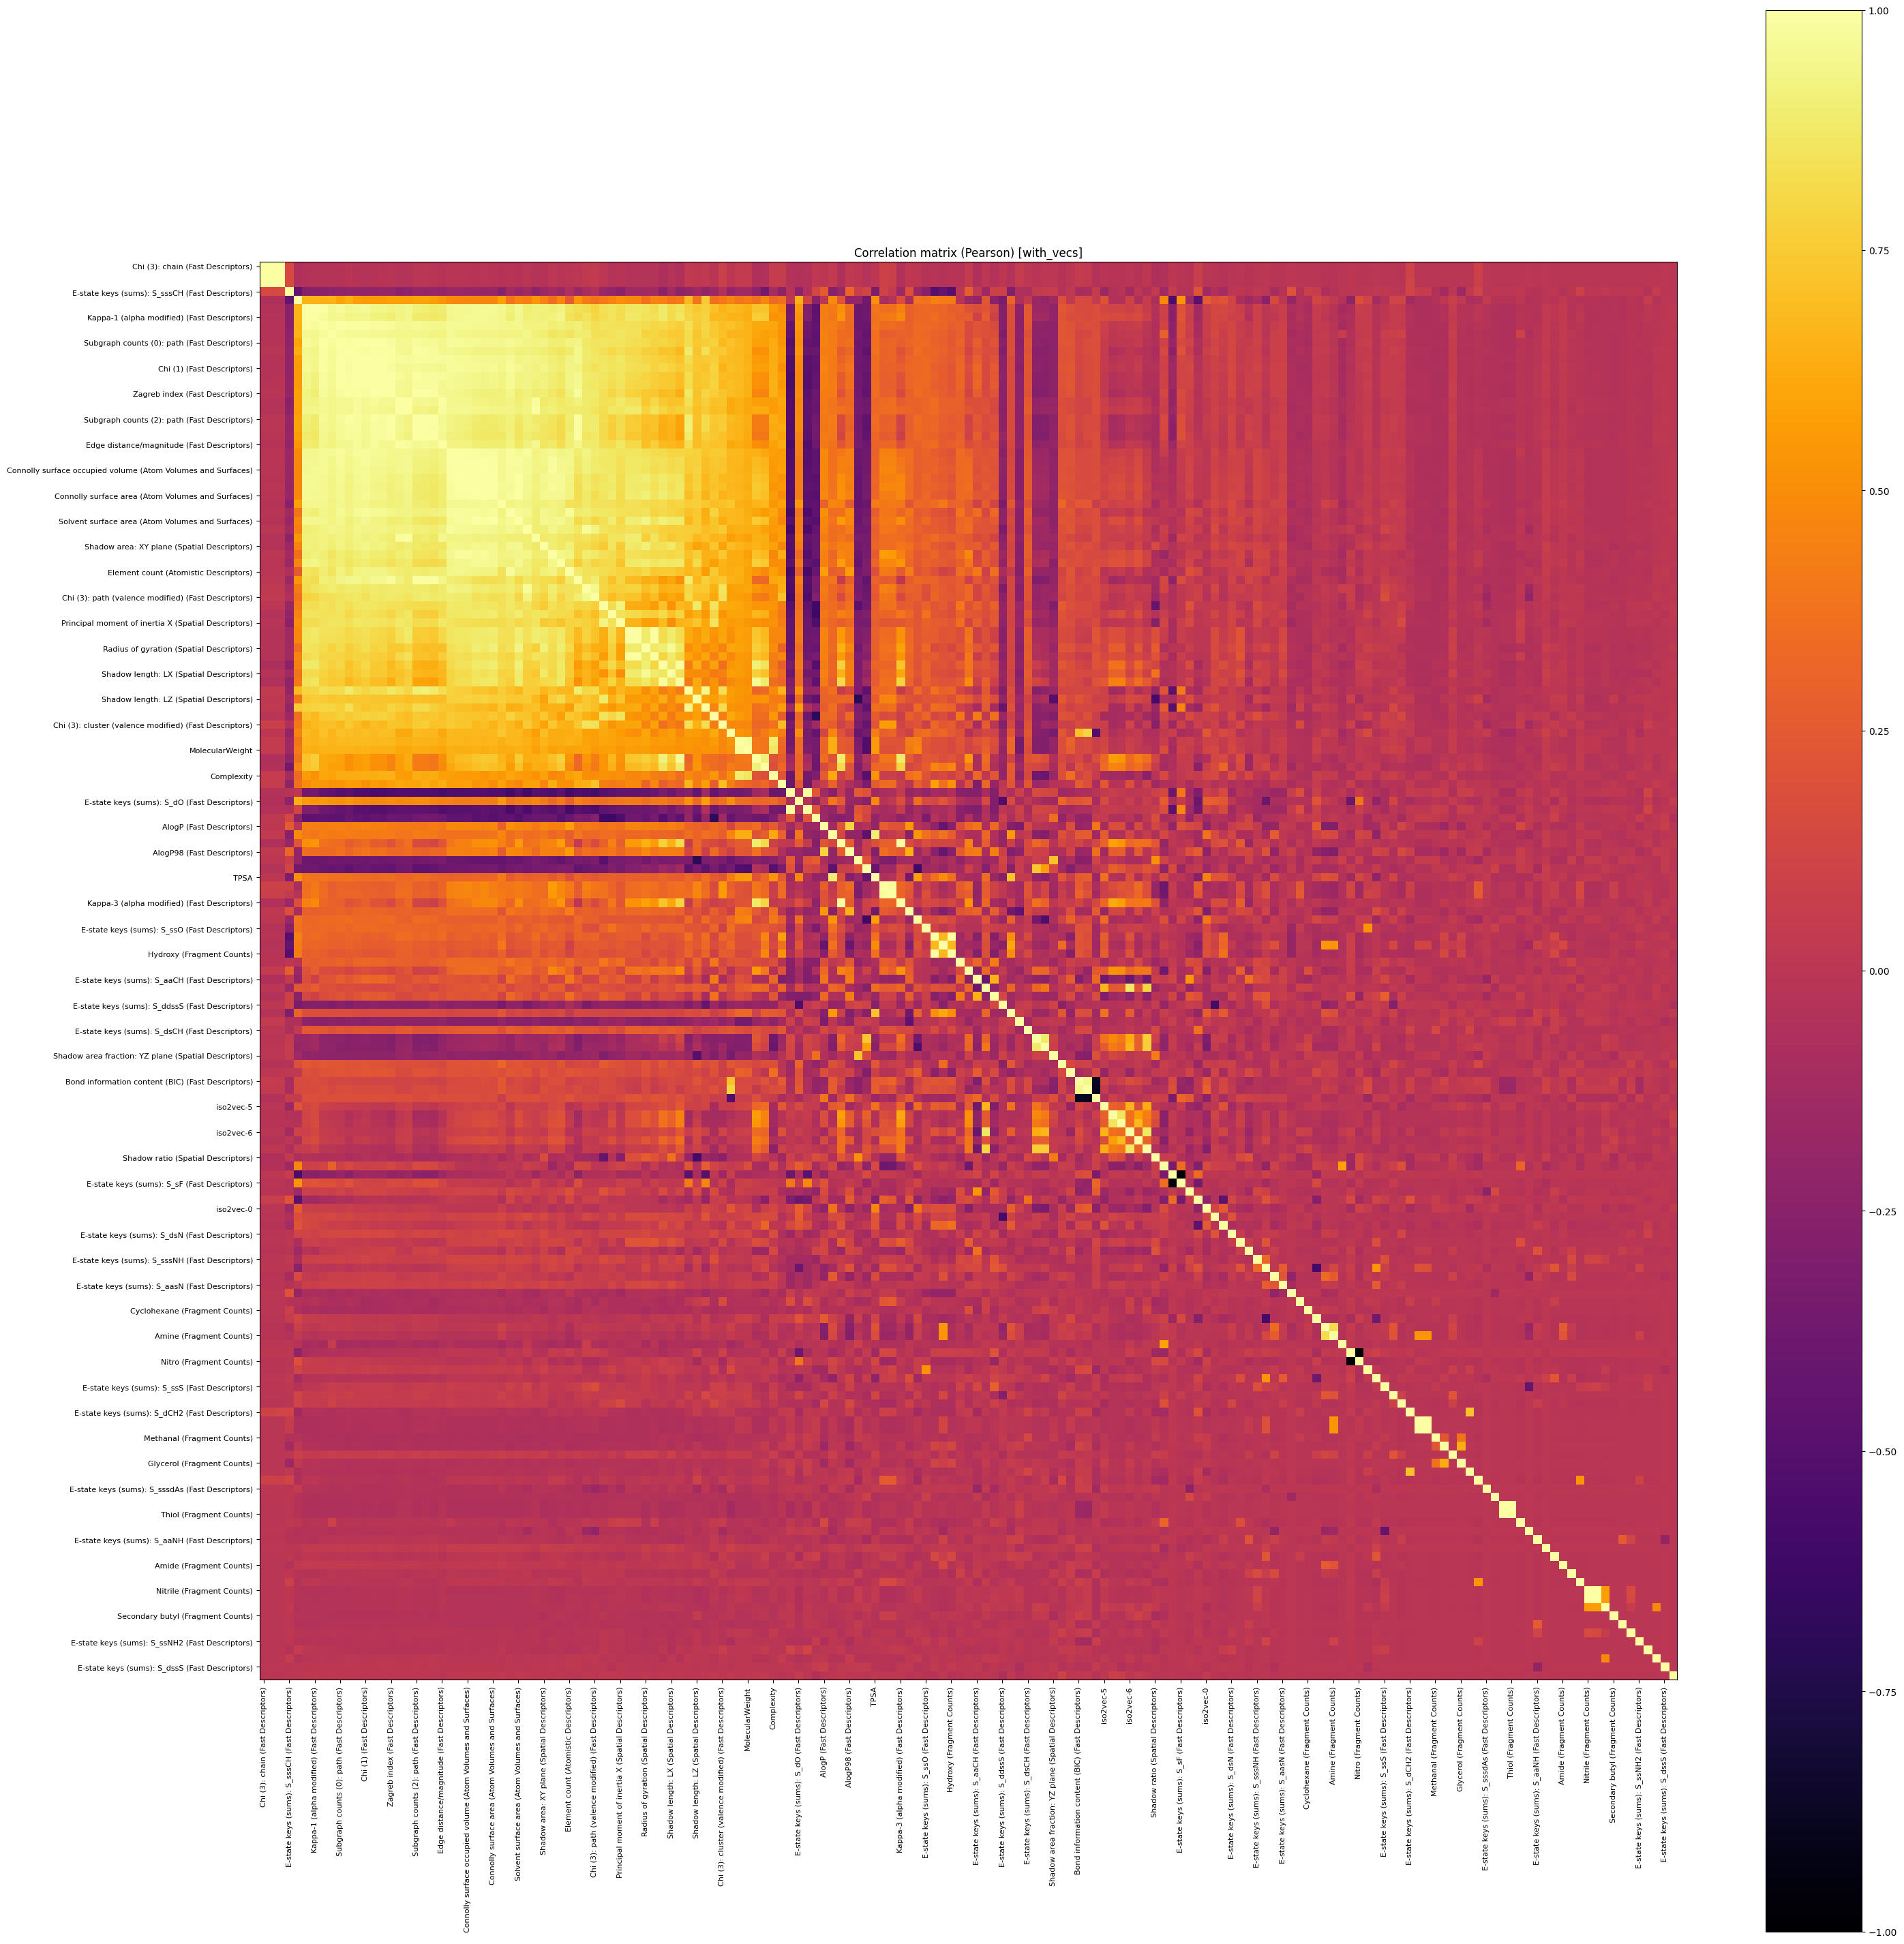

[with_vecs] top-k korelacje zapisane do: analiza\with_vecs_top_correlations.md
[corr] zapisano: analiza\corr\corr_without_vecs.png


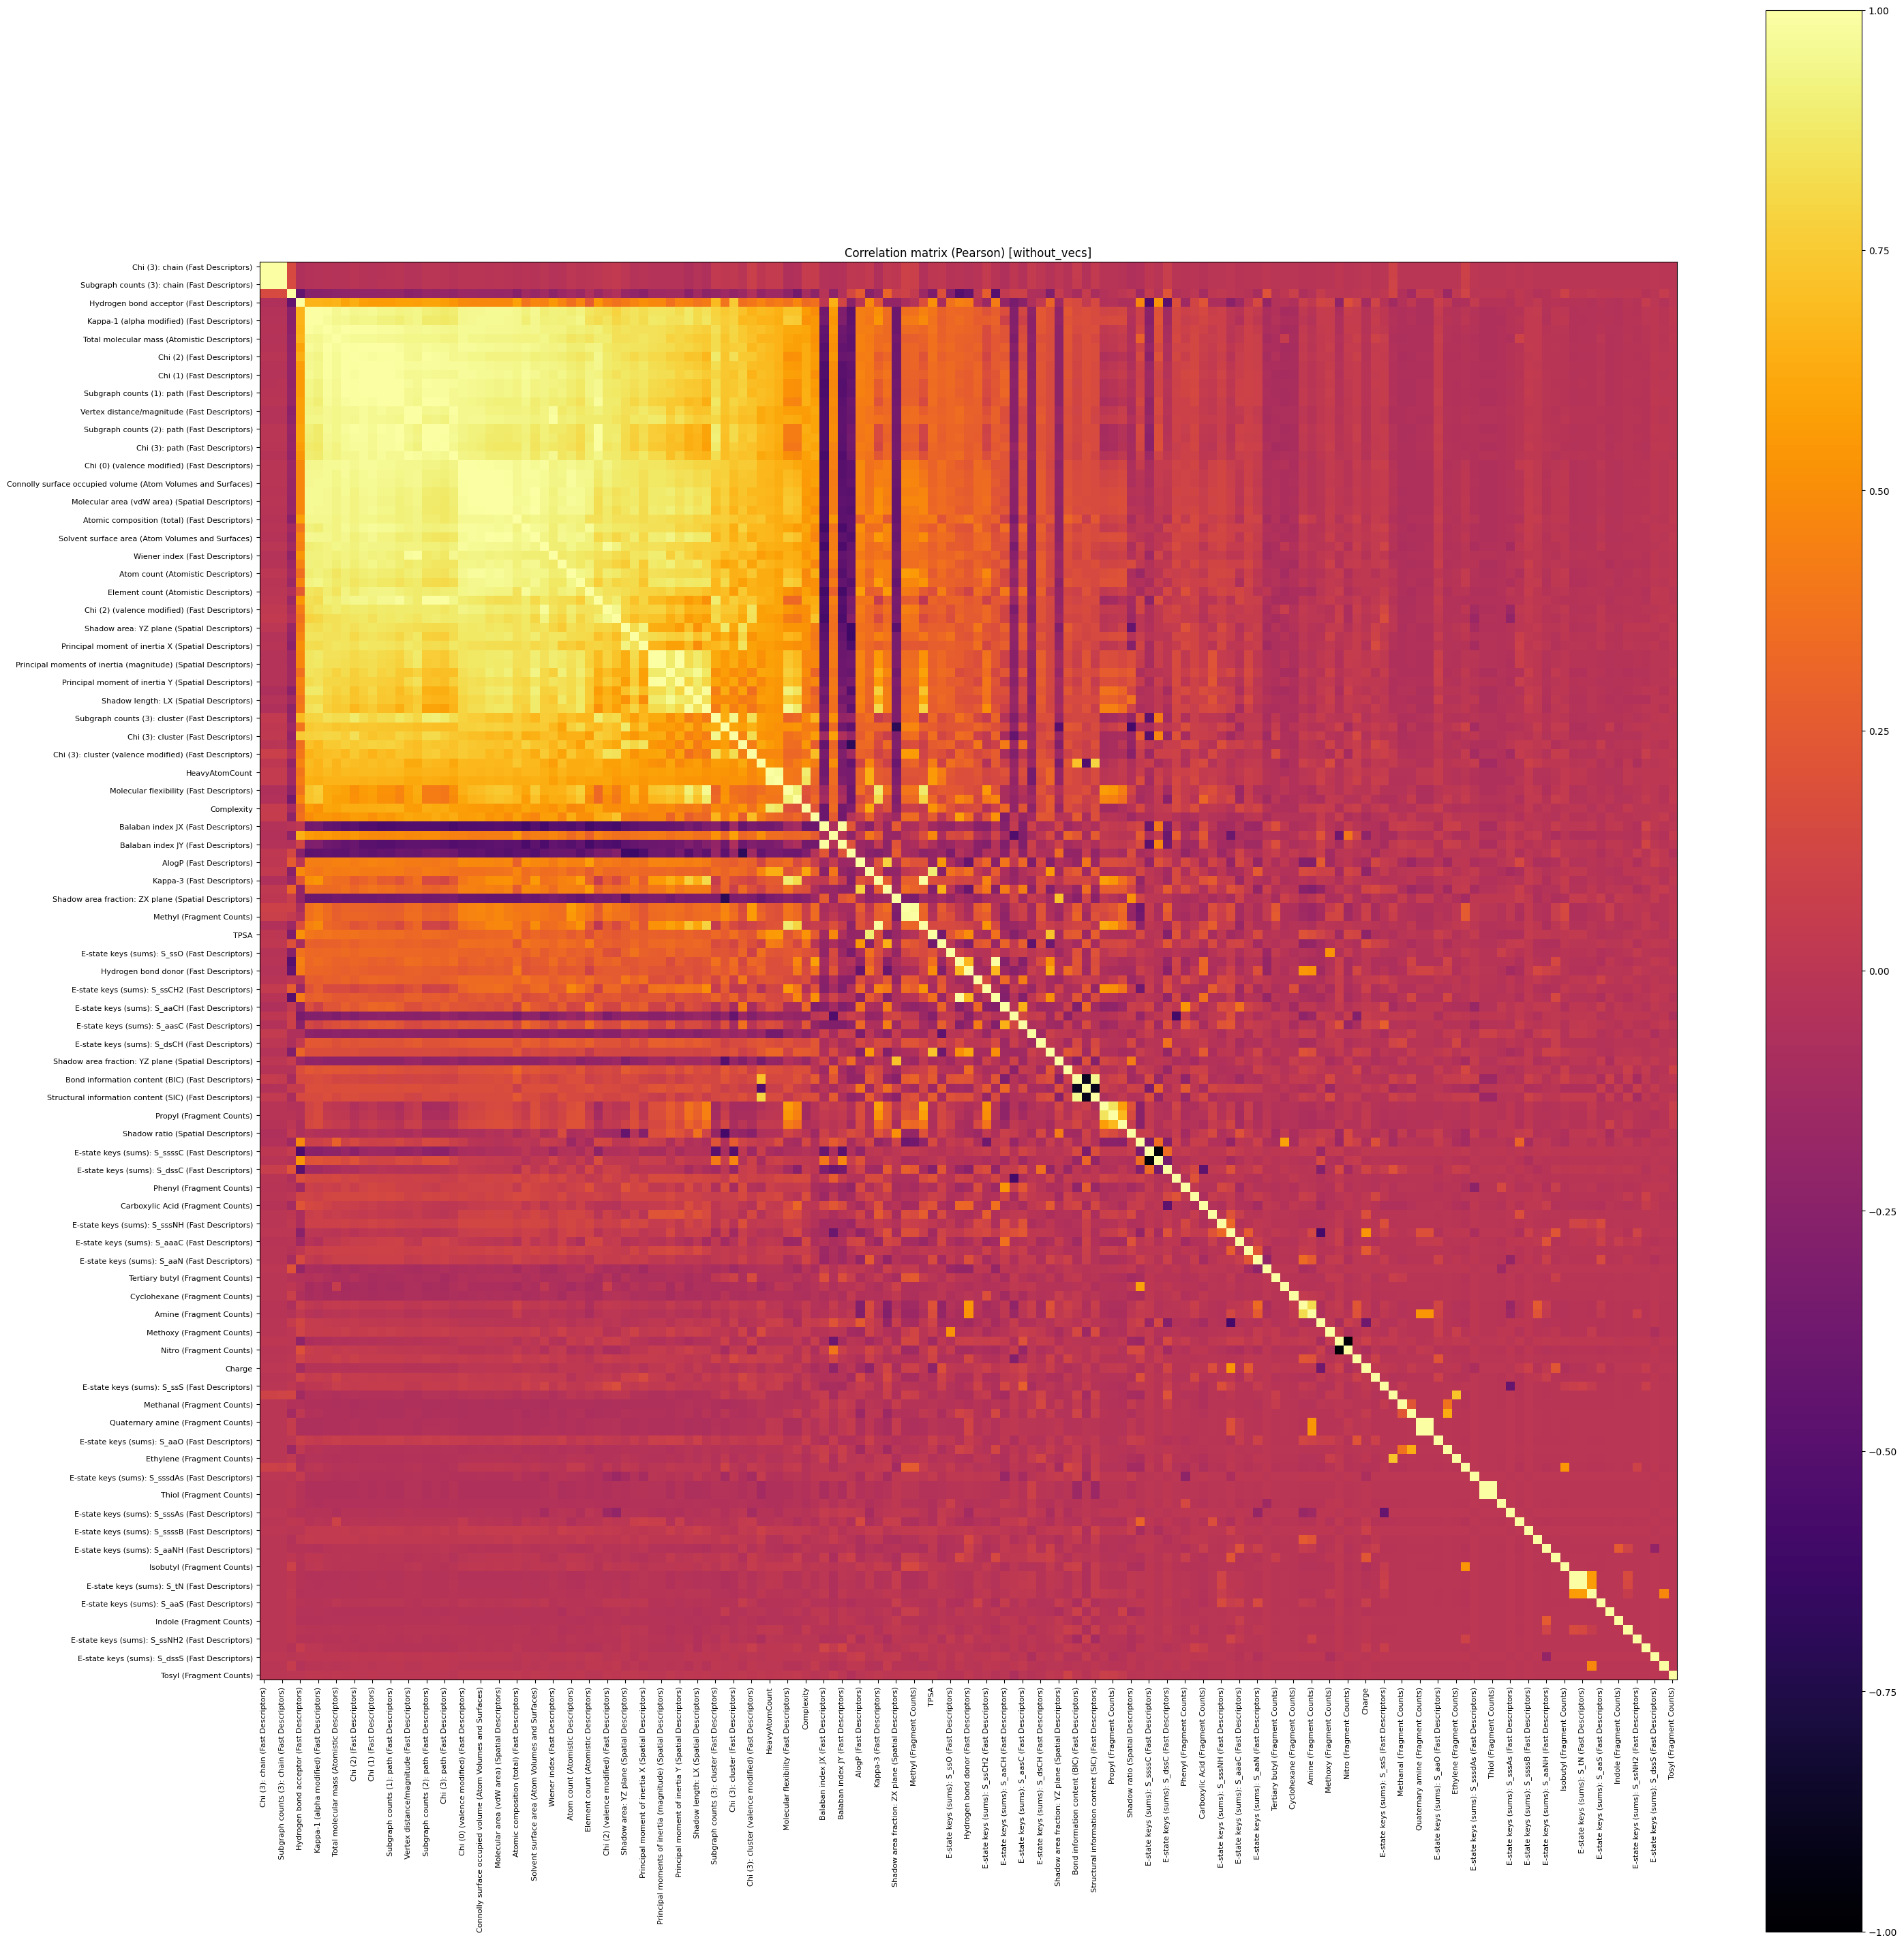

[without_vecs] top-k korelacje zapisane do: analiza\without_vecs_top_correlations.md


In [ ]:
CORR_OUTDIR.mkdir(parents=True, exist_ok=True)

for name, dfv in {
    "with_vecs": df_with_vecs,
    "without_vecs": df_without_vecs,
}.items():
    png_path = (CORR_OUTDIR / f"corr_{name}.png") if CORR_SAVE else None
    plot_corr_readable(
        dfv,
        title=f"Correlation matrix (Pearson) [{name}]",
        out_png=str(png_path) if png_path else None,
        max_labels=CORR_MAX_LABELS,
        cmap=CORR_CMAP,
        dpi=CORR_DPI
    )
    _ = report_top_correlations(dfv, view_name=name, out_dir=OUTPUT_ANALYZE_DIR,
                                topk=CORR_TOPK, min_abs=CORR_MIN_ABS)


# Standarisation

In [39]:
# === STANDARYZACJA (PO IMPUTACJI) ===
views_scaled = {}
scalers = {}
scaled_cols = {}

for name, dfv in {
    "with_vecs": df_with_vecs.copy(),
    "without_vecs": df_without_vecs.copy(),
}.items():
    exclude = [TARGET_COL] if (TARGET_COL and TARGET_COL in dfv.columns) else []
    dfv_scaled, scaler, cols = scale_numeric_inplace(dfv, exclude=exclude)
    views_scaled[name] = dfv_scaled
    scalers[name] = scaler
    scaled_cols[name] = cols
    print(f"[{name}] Skalowano kolumn: {len(cols)}")

# Finalne przypisania – reszta pipeline'u korzysta z tych zmiennych:
df_with_vecs_scaled    = views_scaled["with_vecs"]
df_without_vecs_scaled = views_scaled["without_vecs"]


[with_vecs] Skalowano kolumn: 166


C:\Users\jakub\AppData\Local\Temp\ipykernel_26404\765435601.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671

[without_vecs] Skalowano kolumn: 156


C:\Users\jakub\AppData\Local\Temp\ipykernel_26404\765435601.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671 -0.07848671
 -0.07848671

# Saving datasets

In [ ]:
save_df(views_scaled["with_vecs"],    OUTPUT_CLEAN_DIR, BASE_WITH_VECS,    suffix="scaled")
save_df(views_scaled["without_vecs"], OUTPUT_CLEAN_DIR, BASE_WITHOUT_VECS, suffix="scaled")

print("Zapisano:")
print(" -", OUTPUT_CLEAN_DIR / f"{BASE_WITH_VECS}_scaled.parquet")
print(" -", OUTPUT_CLEAN_DIR / f"{BASE_WITH_VECS}_scaled.csv")
print(" -", OUTPUT_CLEAN_DIR / f"{BASE_WITHOUT_VECS}_scaled.parquet")
print(" -", OUTPUT_CLEAN_DIR / f"{BASE_WITHOUT_VECS}_scaled.csv")


Zapisano:
 - data\clean\dataset_with_vec_expanded_scaled.parquet
 - data\clean\dataset_with_vec_expanded_scaled.csv
 - data\clean\dataset_without_vec_expanded_scaled.parquet
 - data\clean\dataset_without_vec_expanded_scaled.csv


In [ ]:
from hmbfr import HmbFR


X = df_with_vecs_scaled.drop(columns=["DeltaG"])
y = df_with_vecs_scaled["DeltaG"]

ranker = HmbFR(class_strategy="quantile", n_bins=3, agg_features="max", use_backward=True)
ranker.fit(X, y)

scores = (pd.Series(ranker.feature_importances_, index=ranker.numeric_columns_)
            .sort_values(ascending=False))
display(scores.head(20))

X_top50 = ranker.transform(X, top_k=50, mode="select")
X_compressed = ranker.transform(X, mode="compress")
